# Walmart Weekly Sales Prediction

## Business Context

Walmart’s Marketing Department aims to better anticipate store-level revenue
in order to optimize promotional campaigns and adapt marketing strategies
to changing economic conditions.

Weekly sales are influenced by a variety of internal and external factors,
including:

- Seasonal periods such as holidays
- Inflation levels (CPI)
- Fuel prices
- Unemployment rate
- Store-specific characteristics

Being able to accurately predict future weekly sales would allow business teams to:

- Adjust promotional intensity
- Anticipate periods of reduced consumer spending
- Optimize inventory planning
- Improve marketing campaign timing

This project therefore focuses on building a supervised machine learning model
capable of estimating weekly store sales based on economic indicators
and store-related information.

## Imports

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, root_mean_squared_error

## Data Loading

In [3]:
walmart_df = pd.read_csv("Walmart_Store_sales.csv")
walmart_df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


## Dataset Overview

In [4]:
walmart_df.describe(include='all')

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


In [5]:
print("Number of rows : {}".format(walmart_df.shape[0]))
print()

print("Percentage of missing values: ")
display(100 * walmart_df.isnull().sum() / walmart_df.shape[0])

Number of rows : 150

Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

### Weekly Sales Distribution

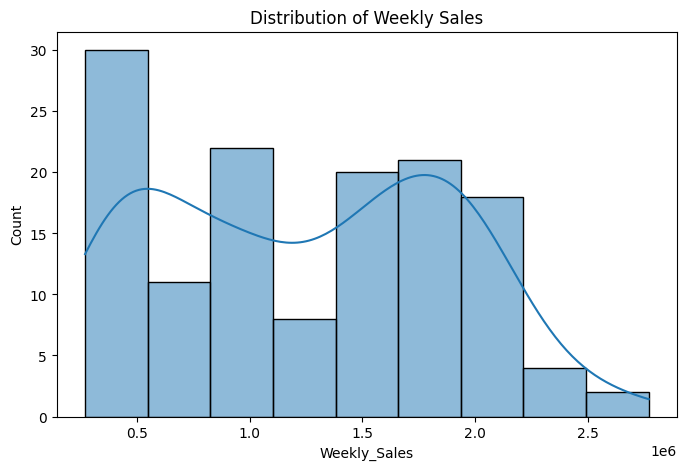

In [6]:
plt.figure(figsize=(8,5))
sns.histplot(walmart_df["Weekly_Sales"], kde=True)
plt.title("Distribution of Weekly Sales")
plt.show()

#### Interpretation

Weekly sales are unevenly distributed across observations, with some weeks showing significantly higher revenues than others.

This confirms that store performance is not homogeneous over time and may depend on contextual factors such as economic conditions or seasonal effects. In practice, some stores are able to reach weekly sales above 2 million dollars, while others remain below 500,000 dollars.

This variability suggests that predicting weekly sales requires taking into account both store-specific characteristics and external indicators.

### Weekly Sales vs Holiday

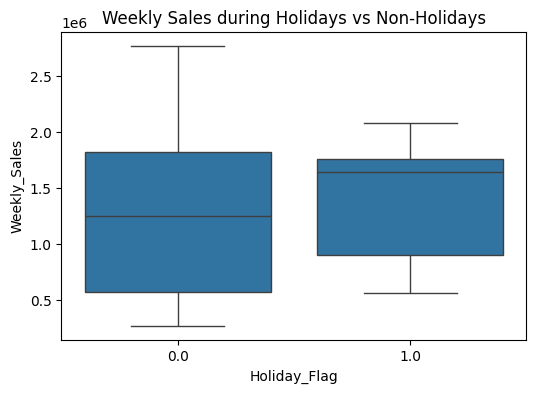

In [7]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Holiday_Flag", y="Weekly_Sales", data=walmart_df)
plt.title("Weekly Sales during Holidays vs Non-Holidays")
plt.show()

#### Interpretation

Weekly sales tend to be slightly higher during holiday weeks compared to non-holiday periods. Sales values also appear more concentrated around higher ranges when a holiday occurs.

From a business standpoint, this is consistent with an increase in customer traffic and seasonal purchasing behaviour during holidays. This indicates that holiday periods may contribute positively to store performance.

### Weekly Sales vs Economic Indicators

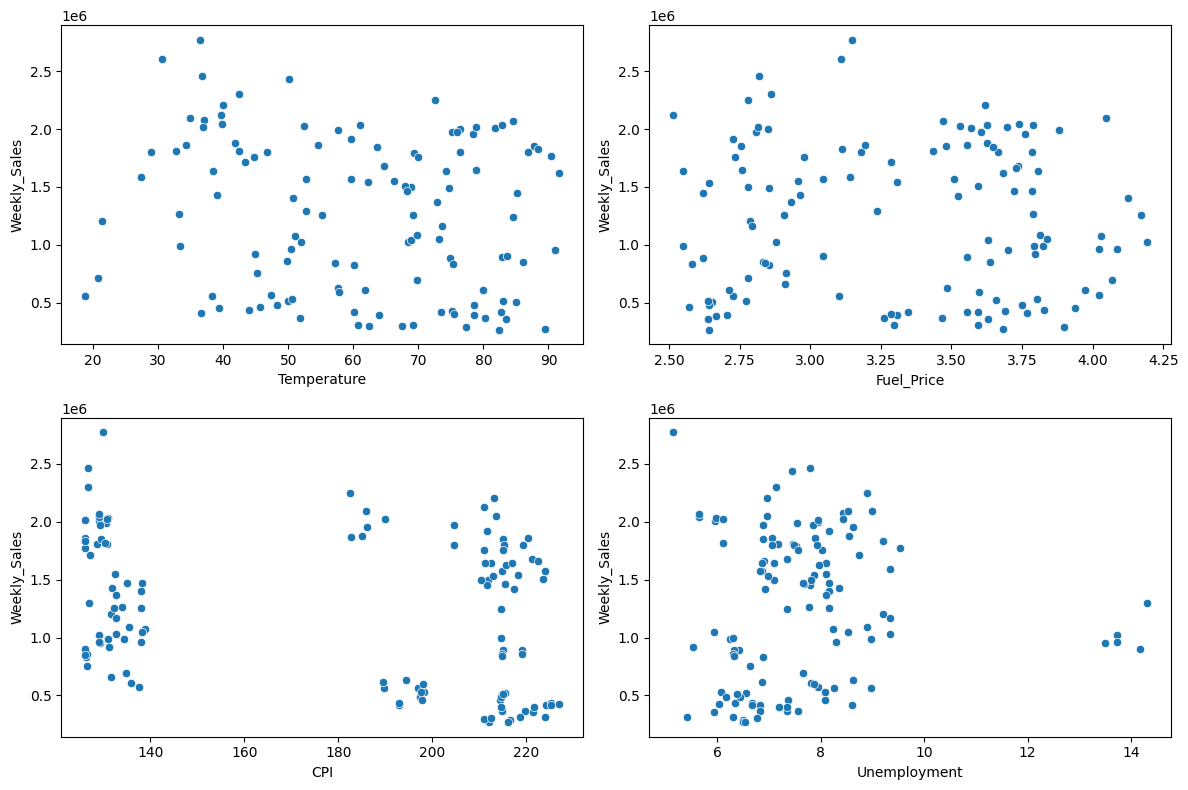

In [8]:
fig, axs = plt.subplots(2,2, figsize=(12,8))

sns.scatterplot(x="Temperature", y="Weekly_Sales", data=walmart_df, ax=axs[0,0])
sns.scatterplot(x="Fuel_Price", y="Weekly_Sales", data=walmart_df, ax=axs[0,1])
sns.scatterplot(x="CPI", y="Weekly_Sales", data=walmart_df, ax=axs[1,0])
sns.scatterplot(x="Unemployment", y="Weekly_Sales", data=walmart_df, ax=axs[1,1])

plt.tight_layout()
plt.show()

#### Interpretation: Temperature vs Weekly Sales

No clear trend can be identified between temperature and weekly sales. Sales remain highly dispersed regardless of temperature levels.

This suggests that temperature alone does not directly influence overall store revenue, even though it may still affect the demand for specific product categories.

#### Interpretation: Fuel Price vs Weekly Sales

Weekly sales do not seem to vary consistently with changes in fuel prices. Observations remain widely spread across all fuel price values.

This indicates that short-term fluctuations in fuel cost may not have a strong immediate impact on in-store spending behaviour.

#### Interpretation: CPI vs Weekly Sales

Higher CPI values are generally associated with lower weekly sales levels.

This may reflect the impact of inflation on consumers' purchasing power, as increasing prices can lead households to reduce their overall spending.

### Interpretation: Unemployment vs Weekly Sales

A slight downward tendency in weekly sales can be observed when unemployment increases.

Higher unemployment rates may reduce disposable income, which can negatively affect customer spending in retail stores.

### Correlation Matrix

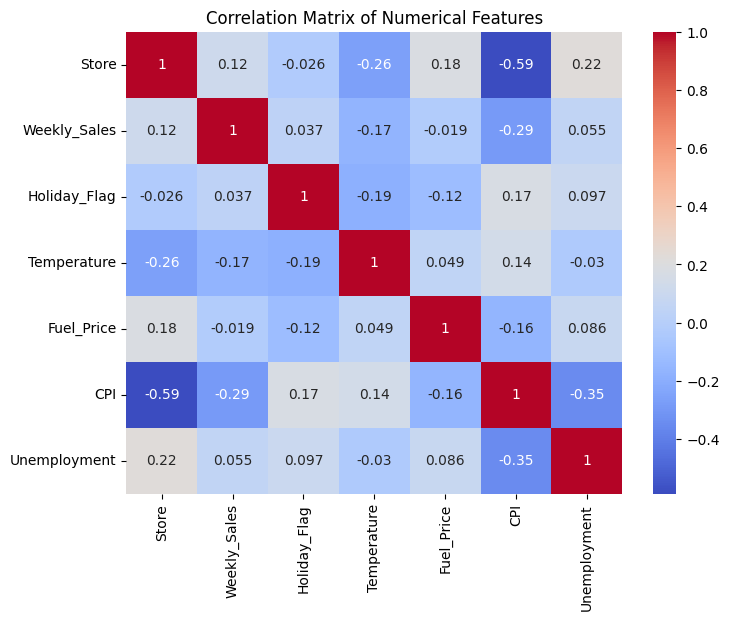

In [9]:
plt.figure(figsize=(8,6))
sns.heatmap(walmart_df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

#### Interpretation

The correlation matrix confirms that CPI is moderately negatively correlated with weekly sales, while temperature and fuel price show very limited linear relationships with the target variable.

Store-level differences also appear to play a role in explaining sales variability, suggesting that part of the observed performance may be linked to structural characteristics rather than purely economic conditions.

## Target Cleaning & Data cleaning

In [10]:
walmart_df = walmart_df.dropna(subset=['Weekly_Sales'])

In [11]:
walmart_df = walmart_df.dropna(subset=['Date','Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'])

## Date Feature Engineering

The Date column cannot be directly used in a regression model.  
We extract additional time-related numerical features from this variable.

In [12]:
walmart_df['Date'] = pd.to_datetime(walmart_df['Date'], format="%d-%m-%Y")

walmart_df['Year'] = walmart_df['Date'].dt.year
walmart_df['Month'] = walmart_df['Date'].dt.month
walmart_df['Day'] = walmart_df['Date'].dt.day
walmart_df['DayOfWeek'] = walmart_df['Date'].dt.dayofweek

In [13]:
walmart_df = walmart_df.drop(columns=['Date'])

In [14]:
walmart_df['Holiday_Flag'].isna().sum()

np.int64(0)

## Outliers Removal

In [15]:
num_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

for col in num_cols:
    mean = walmart_df[col].mean()
    std = walmart_df[col].std()
    
    walmart_df = walmart_df[
        (walmart_df[col] >= mean - 3*std) &
        (walmart_df[col] <= mean + 3*std)
    ]


## Features and Target Separation

In [16]:
X = walmart_df.drop('Weekly_Sales',axis=1)
y = walmart_df['Weekly_Sales']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,shuffle=True
)

In [18]:
categorical_features = ["Store", "Holiday_Flag"]
numerical_features = [
    "Temperature", "Fuel_Price", "CPI",
    "Unemployment", "Year", "Month",
    "Day", "DayOfWeek"
]

In [19]:
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

## Baseline Model

In [21]:
baseline_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LinearRegression())
])

In [22]:
baseline_pipeline.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Model Evaluation

In [23]:
y_train_pred = baseline_pipeline.predict(X_train)
y_test_pred = baseline_pipeline.predict(X_test)

print(f"Baseline Train R2: {r2_score(y_train, y_train_pred):.4f}")
print(f"Baseline Test R2: {r2_score(y_test, y_test_pred):.4f}")

print(f"Baseline Train rmse: {root_mean_squared_error(y_train, y_train_pred):.2f}")
print(f"Baseline Test rmse: {root_mean_squared_error(y_test, y_test_pred):.2f}")

Baseline Train R2: 0.9865
Baseline Test R2: 0.9389
Baseline Train rmse: 83129.39
Baseline Test rmse: 141158.17


#### Interpretation

The RMSE values indicate that the model makes an average prediction error of approximately 83,000 dollars on the training set and 141,000 dollars on the testing set.

Given that weekly sales range from a few hundred thousand to several million dollars, this level of error remains relatively limited in proportion to total revenue.

However, the increase in RMSE between training and testing sets suggests that the model may be slightly overfitting the training data.

##  Regularized Model - Ridge Regression

In [24]:
ridge_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", Ridge(alpha=1.0))
])

In [25]:
ridge_pipeline.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Ridge Model Evaluation

In [26]:
y_train_pred_ridge = ridge_pipeline.predict(X_train)
y_test_pred_ridge = ridge_pipeline.predict(X_test)

print(f"Ridge Train R2:, {r2_score(y_train, y_train_pred_ridge):.4f}")
print(f"Ridge Test R2:, {r2_score(y_test, y_test_pred_ridge):.4f}")

print(f"Ridge Train RMSE:, {root_mean_squared_error(y_train, y_train_pred_ridge):.2f}")
print(f"Ridge Test RMSE:, {root_mean_squared_error(y_test, y_test_pred_ridge):.2f}")

Ridge Train R2:, 0.9301
Ridge Test R2:, 0.7838
Ridge Train RMSE:, 189085.58
Ridge Test RMSE:, 265492.24


#### Interpretation

The Ridge regression model with alpha = 1.0 shows a decrease in performance compared to the baseline linear regression model.

Both the R² score and RMSE have deteriorated on the test set, suggesting that the regularization strength may be too high. In this case, the model appears to be underfitting the data by excessively penalizing the regression coefficients.

This highlights the importance of properly tuning the regularization parameter in order to achieve an optimal balance between bias and variance.

## Ridge Hyperparameter Tuning with Cross-Validation

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
param_grid = {
    "model__alpha": [0.001, 0.01, 0.1, 1, 10, 100]
}

In [29]:
ridge_grid = GridSearchCV(
    ridge_pipeline,
    param_grid,
    cv=5,
    scoring="r2"
)

In [30]:
ridge_grid.fit(X_train, y_train)

ridge_grid.best_params_

{'model__alpha': 0.1}

## Best Ridge Model Evaluation

In [31]:
best_ridge = ridge_grid.best_estimator_

y_train_pred_ridge = best_ridge.predict(X_train)
y_test_pred_ridge = best_ridge.predict(X_test)

print(f"Best Ridge Train R2:, {r2_score(y_train, y_train_pred_ridge):.4f}")
print(f"Best Ridge Test R2:, {r2_score(y_test, y_test_pred_ridge):.4f}")

print(f"Best Ridge Train RMSE:, {root_mean_squared_error(y_train, y_train_pred_ridge):.2f}")
print(f"Best Ridge Test RMSE:, {root_mean_squared_error(y_test, y_test_pred_ridge):.2f}")

Best Ridge Train R2:, 0.9839
Best Ridge Test R2:, 0.8370
Best Ridge Train RMSE:, 90766.19
Best Ridge Test RMSE:, 230547.66


#### Interpretation

Cross-validation identified an optimal regularization parameter of alpha = 0.1 for the Ridge regression model.

Compared to the baseline linear regression, the tuned Ridge model shows a decrease in performance on the test set. The R² score dropped from 0.94 to 0.84, while the RMSE increased from approximately 141,000 dollars to over 230,000 dollars.

Although regularization slightly reduced the gap between training and testing performance, it also introduced additional bias, leading to less accurate predictions overall.

This suggests that, in this context, the baseline linear regression model provides better predictive performance than the regularized Ridge model.

## Regularized Model - Lasso Regression Lasso

In [32]:
lasso_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", Lasso(max_iter=10000, tol=0.001))
])

In [33]:
param_grid_lasso = {
    "model__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

In [34]:
lasso_grid = GridSearchCV(
    lasso_pipeline,
    param_grid_lasso,
    cv=5,
    scoring="r2"
)

In [35]:
lasso_grid.fit(X_train, y_train)

lasso_grid.best_params_

c:\Users\BBelk\anaconda3\envs\ml-analytics-env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.428e+10, tolerance: 2.251e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\BBelk\anaconda3\envs\ml-analytics-env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.207e+11, tolerance: 2.264e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\BBelk\anaconda3\envs\ml-analytics-env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

{'model__alpha': 10}

## Best Lasso Model Evaluation

In [36]:
best_lasso = lasso_grid.best_estimator_

y_train_pred_lasso = best_lasso.predict(X_train)
y_test_pred_lasso = best_lasso.predict(X_test)

print(f"Best Lasso Train R2: {r2_score(y_train, y_train_pred_lasso):.4f}")
print(f"Best Lasso Test R2: {r2_score(y_test, y_test_pred_lasso):.4f}")

print(f"Best Lasso Train RMSE: {root_mean_squared_error(y_train, y_train_pred_lasso):.2f}")
print(f"Best Lasso Test RMSE: {root_mean_squared_error(y_test, y_test_pred_lasso):.2f}")

Best Lasso Train R2: 0.9864
Best Lasso Test R2: 0.9406
Best Lasso Train RMSE: 83286.89
Best Lasso Test RMSE: 139175.73


#### Interpretation

Cross-validation identified an optimal regularization parameter of alpha = 10 for the Lasso regression model.

Compared to the baseline linear regression, the tuned Lasso model achieved a slight improvement in predictive performance on the test set. The R² score increased from 0.94 to 0.94, while the RMSE decreased from approximately 141,000 dollars to 139,000 dollars.

This indicates that the Lasso model is able to better generalize to unseen data by reducing the influence of less informative features through coefficient shrinkage.

As a result, the Lasso regression model provides the most accurate predictions of weekly sales among the models evaluated in this project.

In [37]:
feature_names = best_lasso.named_steps["preprocessing"].get_feature_names_out()

coefficients = best_lasso.named_steps["model"].coef_

lasso_coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
}).sort_values(by="coefficient", key=abs, ascending=False)

lasso_coef_df.head(10)

,feature,coefficient
12,cat__Store_5.0,-1.570059e+06
16,cat__Store_9.0,-1.519317e+06
11,cat__Store_4.0,1.495365e+06
10,cat__Store_3.0,-1.492013e+06
18,cat__Store_13.0,1.353085e+06
17,cat__Store_10.0,1.276715e+06
15,cat__Store_8.0,-1.086954e+06
21,cat__Store_16.0,-1.053082e+06
14,cat__Store_7.0,-9.605758e+05
19,cat__Store_14.0,9.123041e+05


#### Interpretation of Feature Influence on Weekly Sales

By analysing the coefficients of the Lasso regression model, it appears
that store-specific characteristics have the strongest influence
on predicted weekly sales.

In other words, not all Walmart stores perform equally:
some locations are consistently associated with higher predicted revenue,
while others tend to generate lower weekly sales.

This difference may be explained by a variety of local factors such as:
- Customer purchasing power
- Regional economic conditions
- Store size or attractiveness
- Population density or local competition

From a business standpoint, this highlights the importance of adapting
marketing strategies to each store’s specific context.

For example:

- High-performing stores could benefit from targeted promotional campaigns
  aimed at maximizing revenue during peak demand periods.

- Lower-performing stores may require additional marketing support
  or pricing incentives in order to stimulate customer traffic.

Overall, these insights provide actionable information that can help
marketing teams better allocate promotional budgets and tailor
campaign strategies according to the economic and demographic
environment of each store.

## Final Model Selection

After comparing the different models tested in this project,
the Lasso regression model was selected as the final solution
for predicting weekly sales across Walmart stores.

While the baseline linear regression already provided strong
predictive performance, the introduction of regularization
through the Lasso model allowed us to slightly improve the model’s
ability to generalize to unseen data.

By reducing the influence of less informative variables,
the Lasso regression helps limit overfitting while retaining
the most relevant predictors of store revenue.

In practice, this results in more stable predictions when the model
is applied to new observations, which is particularly important
for business planning purposes.

For Walmart’s marketing teams, relying on a model that balances
predictive accuracy and robustness ensures that future sales
estimates can be used with greater confidence when planning:

- Promotional campaigns
- Inventory adjustments
- Budget allocation across stores

For these reasons, the Lasso regression model was retained
as the final predictive model for weekly sales forecasting.

## Conclusion

This project demonstrates that weekly sales in Walmart stores can be reasonably estimated using store-specific information and external economic indicators such as inflation or unemployment rates.

The predictive model highlights the influence of these factors on sales performance and provides a quantitative approach to anticipate revenue variations over time.

Such insights may support business teams in planning marketing campaigns, adapting promotional strategies, or anticipating periods of lower consumer spending based on economic conditions.